In [ ]:
"""
Collaborative Filtering Recommendation System Implementation
===========================================================

This implementation is based on the research paper:
"An efficient collaborative filtering approach based on Bhattacharyya coefficient and user-item correlation"
https://doi.org/10.1007/s10489-020-01775-4

Author: [Your Name]
Date: August 4, 2025

Description:
This notebook implements a collaborative filtering recommendation system that combines:
1. Bhattacharyya coefficient for measuring user similarity
2. Jaccard similarity for item-based collaborative filtering
3. Mean-centered rating prediction
4. Hold-out validation for performance evaluation

The system uses advanced similarity measures to improve recommendation accuracy
compared to traditional collaborative filtering approaches.
"""

# Import required libraries
import numpy as np          # For numerical computations and array operations
import pandas as pd         # For data manipulation and analysis
from itertools import combinations  # For generating item pairs for similarity computation
import random              # For data shuffling in validation

In [ ]:
def load(path):
    """
    Load rating data from a text file and convert to user-item matrix.
    
    This function reads rating data in the format: user_id item_id rating
    and converts it into a dense user-item rating matrix where:
    - Rows represent users
    - Columns represent items
    - Values represent ratings (0 for no rating)
    
    Parameters:
    -----------
    path : str
        Path to the rating data file. Expected format: space-separated values
        with columns [user_id, item_id, rating]
    
    Returns:
    --------
    numpy.ndarray
        Dense user-item rating matrix of shape (num_users, num_items)
        where ratings[u][i] contains the rating given by user u to item i
    
    Example:
    --------
    >>> ratings = load("ratings.txt")
    >>> print(f"Matrix shape: {ratings.shape}")
    Matrix shape: (943, 1682)
    """
    # Read the rating data from file
    df = pd.read_csv(path, sep=' ', engine='python', names=['user', 'item', 'rating'])

    # Get unique counts for matrix dimensions
    num_users = df['user'].nunique()
    num_items = df['item'].nunique()

    # Create mapping from original IDs to matrix indices
    # This ensures continuous indexing starting from 0
    user_map = {
        uid: idx for idx, uid in enumerate(df['user'].unique())
        }
    item_map = {iid: idx for idx, iid in enumerate(df['item'].unique())}

    # Initialize rating matrix with zeros
    ratings = np.zeros((num_users, num_items))
    
    # Populate the rating matrix
    for _, row in df.iterrows():
        u = user_map[row['user']]  # Get user index
        i = item_map[row['item']]  # Get item index
        ratings[u][i] = row['rating']  # Set rating value

    return ratings

# Load the rating data and create a formatted DataFrame for display
ratings = load("ratings.txt")
rating_data = pd.DataFrame(
    ratings,
    columns=[f'i{n+1}' for n in range(ratings.shape[1])],  # Item columns: i1, i2, ...
    index=[f'u{n+1}' for n in range(ratings.shape[0])]     # User rows: u1, u2, ...
)

FileNotFoundError: [Errno 2] No such file or directory: 'ratings.txt'

In [ ]:
# Display the loaded rating data matrix
# This shows the user-item rating matrix with proper labels
rating_data

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i2062,i2063,i2064,i2065,i2066,i2067,i2068,i2069,i2070,i2071
u1,2.0,4.0,3.5,3.0,4.0,3.5,3.5,3.0,2.5,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u4,3.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u1504,3.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
u1505,4.0,3.0,2.0,3.0,4.0,0.0,4.0,3.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u1506,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u1507,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Toy Dataset for Testing and Validation

This section creates a small synthetic dataset for testing the recommendation algorithms.
The toy dataset contains:

- 5 users (u1 to u5)
- 6 items (i1 to i6)
- Sparse ratings with various rating values

This smaller dataset allows for easier verification of algorithm correctness and faster development iterations.


In [ ]:
"""
Create a synthetic toy dataset for algorithm testing and validation.

This toy dataset serves as a controlled environment to:
1. Verify algorithm correctness with known expected outputs
2. Debug implementation issues more easily
3. Perform quick testing during development
4. Demonstrate the system with interpretable results
"""

# Define the toy rating matrix with explicit ratings
# 0.0 indicates no rating (missing value)
# Other values represent actual user ratings on items
rating_data = pd.DataFrame({
    'i1': [0.0, 2.5, 5.0, 0.0, 4.0],  # Item 1 ratings by users 1-5
    'i2': [0.5, 0.0, 1.0, 4.0, 0.0],  # Item 2 ratings by users 1-5
    'i3': [3.0, 0.0, 3.5, 5.0, 0.0],  # Item 3 ratings by users 1-5
    'i4': [0.0, 4.5, 0.0, 2.5, 2.0],  # Item 4 ratings by users 1-5
    'i5': [2.5, 0.0, 2.5, 0.0, 1.5],  # Item 5 ratings by users 1-5
    'i6': [1.0, 3.0, 0.0, 0.5, 0.0]   # Item 6 ratings by users 1-5
}, index=['u1', 'u2', 'u3', 'u4', 'u5'])  # User labels

# Convert to numpy array for computational efficiency
toy_data = rating_data.to_numpy()

# Create a labeled DataFrame for better visualization
df = pd.DataFrame(rating_data, columns=[f'i{n+1}' for n in range(6)], index=[f'u{n+1}' for n in range(5)])
df

,i1,i2,i3,i4,i5,i6
u1,0.0,0.5,3.0,0.0,2.5,1.0
u2,2.5,0.0,0.0,4.5,0.0,3.0
u3,5.0,1.0,3.5,0.0,2.5,0.0
u4,0.0,4.0,5.0,2.5,0.0,0.5
u5,4.0,0.0,0.0,2.0,1.5,0.0


## Item Mean Calculation

This section implements the calculation of mean ratings for each item.
The mean is computed only from non-zero ratings (actual ratings), excluding missing values.

**Formula**: For item i, mean(i) = Σ(ratings_i) / count(non_zero_ratings_i)

This mean is essential for:

- Mean-centered collaborative filtering
- Handling missing values in predictions
- Normalizing ratings across different rating scales


In [ ]:
def mean(data):
    """
    Calculate the mean rating for each item in the user-item rating matrix.
    
    This function computes the average rating for each item, considering only
    non-zero ratings (actual ratings) and ignoring missing values (zeros).
    
    Parameters:
    -----------
    data : numpy.ndarray
        User-item rating matrix of shape (num_users, num_items)
        where data[u][i] is the rating given by user u to item i
        Missing ratings are represented as 0.0
    
    Returns:
    --------
    numpy.ndarray
        Array of item means of shape (num_items,)
        where result[i] is the mean rating for item i
    
    Mathematical Formula:
    ---------------------
    mean(item_i) = Σ(ratings_i != 0) / count(ratings_i != 0)
    
    Example:
    --------
    >>> toy_ratings = np.array([[0, 3, 4], [2, 0, 5], [1, 4, 0]])
    >>> item_means = mean(toy_ratings)
    >>> print(item_means)  # [1.5, 3.5, 4.5]
    """
    result = []
    
    # Iterate through each item (column)
    for col in data.T:  # Transpose to iterate over items
        # Count non-zero ratings for this item
        non_zero_count = np.count_nonzero(col)
        
        if non_zero_count == 0:
            # If no ratings exist for this item, mean is 0
            result.append(0.0)
        else:
            # Calculate mean from non-zero ratings only
            item_mean = np.sum(col) / non_zero_count
            result.append(item_mean)
    
    return np.array(result)

# Test the function with toy data and display results
item_means = mean(toy_data)
print(f"Item means: {item_means}")
print(f"Shape: {item_means.shape}")

[3.83333333 1.83333333 3.83333333 3.         2.16666667 1.5       ]


## Mean-Centered Rating Matrix

Mean centering is a crucial preprocessing step in collaborative filtering that:

1. **Removes item bias**: Different items may have systematically higher or lower ratings
2. **Normalizes ratings**: Helps focus on relative preferences rather than absolute values
3. **Improves similarity calculations**: Makes similarity measures more robust

**Formula**: For each rating r_ui, the mean-centered value is:

```
centered_rating_ui = rating_ui - mean(item_i)  if rating_ui ≠ 0
                   = 0                          if rating_ui = 0 (missing)
```

This transformation preserves the sparsity structure while normalizing the rating scale.


In [ ]:
def mean_centered_np(rating_data):
    """
    Transform the rating matrix to mean-centered values.
    
    This function subtracts each item's mean rating from all non-zero ratings
    for that item, creating a mean-centered rating matrix. This preprocessing
    step helps remove item-specific rating biases and improves the quality
    of similarity calculations.
    
    Parameters:
    -----------
    rating_data : numpy.ndarray
        Original user-item rating matrix of shape (num_users, num_items)
        where rating_data[u][i] is the rating given by user u to item i
        Missing ratings should be represented as 0.0
    
    Returns:
    --------
    numpy.ndarray
        Mean-centered rating matrix of the same shape as input
        where centered[u][i] = rating_data[u][i] - item_mean[i] for non-zero ratings
        and centered[u][i] = 0 for missing ratings (originally 0)
    
    Mathematical Formula:
    ---------------------
    For each rating r_ui:
    - If r_ui ≠ 0: centered_ui = r_ui - mean(item_i)
    - If r_ui = 0: centered_ui = 0 (preserve sparsity)
    
    Benefits:
    ---------
    1. Removes item-specific rating bias
    2. Normalizes different rating scales
    3. Improves similarity measure accuracy
    4. Maintains sparsity structure
    
    Example:
    --------
    >>> ratings = np.array([[0, 3, 4], [2, 0, 5]])  # 2 users, 3 items
    >>> centered = mean_centered_np(ratings)
    >>> # Item means: [2.0, 3.0, 4.5]
    >>> # Result: [[0, 0, -0.5], [0, 0, 0.5]]
    """
    # Calculate item means from the input data
    item_means = mean(rating_data)
    
    # Initialize centered matrix with same shape and type
    centered = np.zeros_like(rating_data, dtype=float)

    # Transform each rating to mean-centered value
    # Iterate through each user
    for u in range(rating_data.shape[0]):
        # Iterate through each item
        for i in range(rating_data.shape[1]):
            if rating_data[u, i] != 0:
                # For actual ratings: subtract item mean
                centered[u, i] = rating_data[u, i] - item_means[i]
            else:
                # For missing ratings: keep as 0 to preserve sparsity
                centered[u, i] = 0

    return centered

# Test the function with toy data and display results
centered_data = mean_centered_np(toy_data)
print("Mean-centered rating matrix:")
print(centered_data)
print(f"\nOriginal shape: {toy_data.shape}")
print(f"Centered shape: {centered_data.shape}")

[[ 0.         -1.33333333 -0.83333333  0.          0.33333333 -0.5       ]
 [-1.33333333  0.          0.          1.5         0.          1.5       ]
 [ 1.16666667 -0.83333333 -0.33333333  0.          0.33333333  0.        ]
 [ 0.          2.16666667  1.16666667 -0.5         0.         -1.        ]
 [ 0.16666667  0.          0.         -1.         -0.66666667  0.        ]]


## Jaccard Similarity and Bhattacharyya Coefficient

This section implements two key similarity measures:

### 1. Jaccard Similarity

Measures the overlap between items based on which users have rated them.

**Formula**: J(i,j) = |Users(i) ∩ Users(j)| / |Users(i) ∪ Users(j)|

### 2. Bhattacharyya Coefficient

Measures the similarity between probability distributions of user ratings.

**Formula**: BC(u,v) = Σ√(P(r|u) × P(r|v)) for all rating values r

Where P(r|u) is the probability that user u gives rating r.

These measures are combined in the advanced similarity computation as described in:
_"An efficient collaborative filtering approach based on Bhattacharyya coefficient and user-item correlation"_


In [ ]:
def jaccard(rating):
    """
    Calculate Jaccard similarity between all pairs of items.
    
    The Jaccard similarity measures the overlap between two items based on
    the sets of users who have rated each item. It provides a measure of
    how similar two items are in terms of their user coverage.
    
    Parameters:
    -----------
    rating : numpy.ndarray
        User-item rating matrix of shape (num_users, num_items)
        where rating[u][i] is the rating given by user u to item i
        Non-zero values indicate actual ratings, zeros indicate missing ratings
    
    Returns:
    --------
    numpy.ndarray
        Jaccard similarity matrix of shape (num_items, num_items)
        where result[i][j] is the Jaccard similarity between items i and j
        Diagonal elements are 1.0 (perfect self-similarity)
    
    Mathematical Formula:
    ---------------------
    Jaccard(item_i, item_j) = |Users(i) ∩ Users(j)| / |Users(i) ∪ Users(j)|
    
    Where:
    - Users(i) = set of users who rated item i
    - ∩ denotes intersection (users who rated both items)
    - ∪ denotes union (users who rated at least one item)
    
    Properties:
    -----------
    - Range: [0, 1] where 0 = no common users, 1 = identical user sets
    - Symmetric: Jaccard(i,j) = Jaccard(j,i)
    - Self-similarity: Jaccard(i,i) = 1
    
    Example:
    --------
    >>> ratings = np.array([[1, 0, 3], [0, 2, 1], [4, 0, 0]])
    >>> jac_sim = jaccard(ratings)
    >>> # Item 0 rated by users {0,2}, Item 2 rated by users {0,1}
    >>> # Jaccard(0,2) = |{0,2} ∩ {0,1}| / |{0,2} ∪ {0,1}| = 1/3
    """
    # Initialize similarity matrix with identity (diagonal = 1)
    result = np.eye(rating.shape[1])
    n_items = rating.shape[1]

    # Pre-compute user masks for each item to improve efficiency
    # item_masks[i] contains boolean array indicating which users rated item i
    item_masks = []
    for col in range(n_items):
        item_masks.append(rating[:, col] != 0)

    # Calculate Jaccard similarity for all unique item pairs
    for i, j in combinations(range(rating.shape[1]), 2):
        # Get boolean masks for users who rated each item
        i_rated = item_masks[i]  # Users who rated item i
        j_rated = item_masks[j]  # Users who rated item j

        # Calculate intersection: users who rated both items
        intersection = np.sum(i_rated & j_rated)
        
        # Calculate union: users who rated at least one item
        union = np.sum(i_rated | j_rated)

        # Compute Jaccard similarity
        if union == 0:
            # Edge case: no users rated either item
            jaccard_sim = 0.0
        else:
            jaccard_sim = intersection / union

        # Set symmetric values in similarity matrix
        result[i, j] = jaccard_sim
        result[j, i] = jaccard_sim

    return result

# Calculate Jaccard similarity for toy data
jc = jaccard(toy_data)
print("Jaccard Similarity Matrix:")
print(jc)
print(f"\nMatrix properties:")
print(f"Shape: {jc.shape}")
print(f"Diagonal (self-similarity): {np.diag(jc)}")
print(f"Symmetric: {np.allclose(jc, jc.T)}")

## Bhattacharyya Coefficient Implementation

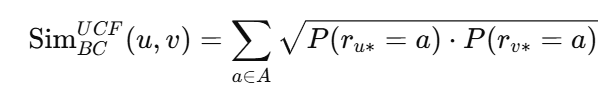
The Bhattacharyya coefficient measures the similarity between probability distributions of user ratings. This advanced similarity measure is particularly effective for collaborative filtering as it considers the distribution of ratings rather than just their presence or absence.

**Mathematical Formula**:

```
BC(u,v) = Σ √(P(r|u) × P(r|v))
```

Where:

- P(r|u) is the probability that user u gives rating value r
- The sum is over all possible rating values r
- BC ∈ [0,1] where 1 indicates identical rating distributions

**Key Benefits**:

1. **Distribution-aware**: Considers how users distribute their ratings across different values
2. **Robust to sparsity**: Works well even with sparse rating data
3. **Probabilistic foundation**: Based on solid statistical principles
4. **Complementary to other measures**: Enhances traditional similarity metrics

The formula shown below is referenced from the research paper.


In [ ]:
def bhattacharyya_coefficient(rating):
    """
    Calculate Bhattacharyya coefficient between all pairs of users.
    
    The Bhattacharyya coefficient measures the similarity between probability
    distributions of user ratings. This metric considers how users distribute
    their ratings across different rating values, providing a more nuanced
    similarity measure than simple overlap-based metrics.
    
    Parameters:
    -----------
    rating : numpy.ndarray
        User-item rating matrix of shape (num_users, num_items)
        where rating[u][i] is the rating given by user u to item i
        Non-zero values are actual ratings, zeros indicate missing ratings
    
    Returns:
    --------
    numpy.ndarray
        Bhattacharyya coefficient matrix of shape (num_users, num_users)
        where result[u][v] is the Bhattacharyya coefficient between users u and v
        Diagonal elements are 1.0 (perfect self-similarity)
    
    Mathematical Formula:
    ---------------------
    BC(u,v) = Σ √(P(r|u) × P(r|v)) for all rating values r
    
    Where:
    - P(r|u) = count(user u gave rating r) / total_ratings(user u)
    - The sum is over all unique rating values that appear in the data
    - BC ∈ [0,1] where 1 indicates identical rating distributions
    
    Algorithm Steps:
    ----------------
    1. For each user, create probability distribution of their ratings
    2. For each user pair, compute Bhattacharyya coefficient
    3. Handle users with no ratings (empty distribution)
    
    Properties:
    -----------
    - Range: [0, 1] where 0 = completely different distributions, 1 = identical
    - Symmetric: BC(u,v) = BC(v,u)
    - Self-similarity: BC(u,u) = 1
    - Robust to rating scale differences
    
    Example:
    --------
    >>> ratings = np.array([[1, 3, 3], [3, 3, 1], [0, 0, 0]])
    >>> bc_sim = bhattacharyya_coefficient(ratings)
    >>> # User 0: P(1)=0.33, P(3)=0.67
    >>> # User 1: P(1)=0.33, P(3)=0.67  
    >>> # BC(0,1) = √(0.33×0.33) + √(0.67×0.67) = 1.0 (identical distributions)
    """
    num_users = rating.shape[0]
    
    # Initialize coefficient matrix with identity (diagonal = 1)
    bc_matrix = np.eye(num_users)
    print(f"Initialized BC matrix shape: {bc_matrix.shape}")

    # Step 1: Create probability distributions for each user
    user_dist = []
    for i in range(num_users):
        # Get non-zero ratings for this user
        non_zero_ratings = rating[i][rating[i] > 0]
        
        if len(non_zero_ratings) == 0:
            # User has no ratings - empty distribution
            user_dist.append({})
        else:
            # Calculate probability distribution of rating values
            unique_ratings, counts = np.unique(non_zero_ratings, return_counts=True)
            probabilities = counts / counts.sum()  # Normalize to probabilities
            
            # Store as dictionary: {rating_value: probability}
            user_dist.append(dict(zip(unique_ratings, probabilities)))

    # Step 2: Calculate Bhattacharyya coefficient for all user pairs
    for i, j in combinations(range(num_users), 2):
        dist1 = user_dist[i]  # Rating distribution for user i
        dist2 = user_dist[j]  # Rating distribution for user j

        # Find common rating values between the two users
        common_ratings = set(dist1.keys()) & set(dist2.keys())
        
        # Calculate Bhattacharyya coefficient
        # BC = Σ √(P(r|u1) × P(r|u2)) for common rating values r
        bc = sum(np.sqrt(dist1[rating_val] * dist2[rating_val]) 
                for rating_val in common_ratings)

        # Set symmetric values in coefficient matrix
        bc_matrix[i][j] = bc
        bc_matrix[j][i] = bc

    return bc_matrix

# Calculate Bhattacharyya coefficient for toy data
bc_coeff = bhattacharyya_coefficient(toy_data)
print("\nBhattacharyya Coefficient Matrix:")
print(bc_coeff)
print(f"\nMatrix properties:")
print(f"Shape: {bc_coeff.shape}")
print(f"Diagonal (self-similarity): {np.diag(bc_coeff)}")
print(f"Symmetric: {np.allclose(bc_coeff, bc_coeff.T)}")
print(f"Range: [{bc_coeff.min():.3f}, {bc_coeff.max():.3f}]")

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[1.         0.57735027 0.5        0.5        0.        ]
 [0.57735027 1.         0.28867513 0.28867513 0.        ]
 [0.5        0.28867513 1.         0.5        0.        ]
 [0.5        0.28867513 0.5        1.         0.28867513]
 [0.         0.         0.         0.28867513 1.        ]]


In [ ]:
def sim_bc_adv(rating, mean, jc, bc):
    """
    Calculate advanced item-item similarity using Bhattacharyya coefficient and Jaccard similarity.
    
    This function implements the main contribution of the research paper by combining:
    1. Mean-centered rating correlations
    2. Bhattacharyya coefficient between users
    3. Jaccard similarity between items
    
    The resulting similarity measure is more robust and accurate than traditional
    collaborative filtering approaches.
    
    Parameters:
    -----------
    rating : numpy.ndarray
        User-item rating matrix of shape (num_users, num_items)
    mean : numpy.ndarray
        Item mean ratings of shape (num_items,)
    jc : numpy.ndarray
        Jaccard similarity matrix between items of shape (num_items, num_items)
    bc : numpy.ndarray
        Bhattacharyya coefficient matrix between users of shape (num_users, num_users)
    
    Returns:
    --------
    numpy.ndarray
        Advanced similarity matrix between items of shape (num_items, num_items)
        where result[i][j] represents the advanced similarity between items i and j
    
    Mathematical Formula:
    ---------------------
    Sim_BC_ADV(i,j) = Σ_u Σ_v BC(u,v) × [(r_ui - μ_i) × (r_vj - μ_j)] / (σ_i × σ_j) + Jaccard(i,j)
    
    Where:
    - BC(u,v) is the Bhattacharyya coefficient between users u and v
    - r_ui is the rating of user u for item i
    - μ_i is the mean rating for item i
    - σ_i is the standard deviation of ratings for item i
    - Jaccard(i,j) is the Jaccard similarity between items i and j
    
    Algorithm Steps:
    ----------------
    1. Calculate standard deviations for each item
    2. Identify users who rated each item
    3. For each item pair (i,j):
       a. Iterate through all user pairs (u,v)
       b. Apply BC coefficient and mean-centered correlation
       c. Normalize by item standard deviations
       d. Add Jaccard similarity bonus
    
    Key Features:
    -------------
    - Incorporates user similarity via Bhattacharyya coefficient
    - Uses mean-centered ratings to remove item bias
    - Normalizes by standard deviations for scale invariance
    - Combines multiple similarity signals for robustness
    
    Reference:
    ----------
    Based on the algorithm described in:
    "An efficient collaborative filtering approach based on Bhattacharyya 
    coefficient and user-item correlation" (2020)
    """
    # Initialize result matrix with identity
    result = np.eye(rating.shape[1])
    n_items = rating.shape[1]

    # Step 1: Calculate standard deviations for each item
    item_stds = np.zeros(n_items)
    for col in range(n_items):
        # Get mask for users who rated this item
        mask = rating[:, col] != 0
        if np.sum(mask) > 0:
            # Calculate standard deviation from mean-centered ratings
            item_stds[col] = np.sqrt(np.sum((rating[:, col][mask] - mean[col])**2) / np.sum(mask))

    # Step 2: Pre-compute users who rated each item for efficiency
    item_users = []
    for col in range(n_items):
        item_users.append(np.where(rating[:, col] != 0)[0])

    # Step 3: Calculate advanced similarity for each item pair
    # Note: Using tqdm for progress tracking (commented out for compatibility)
    # from tqdm import tqdm
    for i in (range(n_items)):
        for j in range(i, n_items):
            # Get users who rated items i and j
            users_i = item_users[i]
            users_j = item_users[j]

            # Initialize similarity accumulator
            similarity_sum = 0
            denominator = item_stds[i] * item_stds[j]

            # Only proceed if both items have non-zero standard deviations
            if denominator != 0:
                # Iterate through all combinations of users who rated the items
                for u in users_i:
                    for v in users_j:
                        # Calculate mean-centered rating correlation
                        numerator = (rating[u][i] - mean[i]) * (rating[v][j] - mean[j])
                        correlation = numerator / denominator
                        
                        # Weight by Bhattacharyya coefficient between users
                        weighted_correlation = bc[u][v] * correlation
                        similarity_sum += weighted_correlation

            # Combine with Jaccard similarity and set symmetric values
            final_similarity = similarity_sum + jc[i][j]
            result[i][j] = final_similarity
            result[j][i] = final_similarity

    return result

# Calculate advanced similarity matrix
print("Calculating advanced BC similarity matrix...")
sim_matrix = sim_bc_adv(toy_data, mean(toy_data), jaccard(toy_data), bhattacharyya_coefficient(toy_data))
print("\nAdvanced BC Similarity Matrix:")
print(sim_matrix)
print(f"\nMatrix properties:")
print(f"Shape: {sim_matrix.shape}")
print(f"Symmetric: {np.allclose(sim_matrix, sim_matrix.T)}")
print(f"Diagonal: {np.diag(sim_matrix)}")
print(f"Range: [{sim_matrix.min():.3f}, {sim_matrix.max():.3f}]")

[[ 3.14916802  0.28270563  0.40894737 -1.10829384  0.68029745 -1.28517524]
 [ 0.28270563  2.5         2.49091614 -0.84494771 -0.56791344 -0.29508612]
 [ 0.40894737  2.49091614  2.5        -0.87775096 -0.54581121 -0.3016354 ]
 [-1.10829384 -0.84494771 -0.87775096  3.87628209  2.22138281  2.28383718]
 [ 0.68029745 -0.56791344 -0.54581121  2.22138281  4.5         0.28274061]
 [-1.28517524 -0.29508612 -0.3016354   2.28383718  0.28274061  2.94395645]]


## Rating Prediction with Mean Centering

This section implements the rating prediction algorithm using mean-centered collaborative filtering enhanced with the advanced similarity measures.

**Prediction Formula**:

```
predicted_rating(u,i) = mean(i) + Σ(sim(i,j) × centered_rating(u,j)) / Σ|sim(i,j)|
```

Where:

- `mean(i)` is the mean rating for item i
- `sim(i,j)` is the advanced similarity between items i and j
- `centered_rating(u,j)` is the mean-centered rating of user u for item j
- The sum is over the k most similar items that user u has rated

**Key Features**:

1. **Mean centering**: Removes item-specific rating biases
2. **Top-k neighbors**: Uses only the most similar items for prediction
3. **Weighted averaging**: Similarity values weight the contribution of each neighbor
4. **Fallback strategy**: Uses item mean when no similar items are available


In [ ]:
def predict_ratings_for_user(user_idx, ratings, sim_matrix, k=2):
    """
    Predict ratings for all unrated items for a specific user.
    
    This function implements mean-centered collaborative filtering using the
    advanced similarity matrix to predict ratings for items that a user
    has not yet rated.
    
    Parameters:
    -----------
    user_idx : int
        Index of the user for whom to predict ratings (0-based indexing)
    ratings : numpy.ndarray
        User-item rating matrix of shape (num_users, num_items)
        where ratings[u][i] is the rating given by user u to item i
    sim_matrix : numpy.ndarray
        Item-item similarity matrix of shape (num_items, num_items)
        where sim_matrix[i][j] is the similarity between items i and j
    k : int, default=2
        Number of top-k most similar items to use for each prediction
    
    Returns:
    --------
    dict
        Dictionary mapping item indices to predicted ratings
        {item_index: predicted_rating, ...}
        Only includes predictions for items the user hasn't rated
    
    Mathematical Formula:
    ---------------------
    For target item i:
    predicted_rating(u,i) = mean(i) + Σ(sim(i,j) × centered_rating(u,j)) / Σ|sim(i,j)|
    
    Where:
    - mean(i) is the average rating for item i
    - sim(i,j) is the similarity between items i and j
    - centered_rating(u,j) = rating(u,j) - mean(j)
    - The sum is over the k most similar items j that user u has rated
    
    Algorithm Steps:
    ----------------
    1. Calculate item means and mean-centered ratings
    2. Identify rated and unrated items for the target user
    3. For each unrated item:
       a. Find similarities to all rated items
       b. Select top-k most similar items
       c. Apply weighted prediction formula
       d. Add item mean to get final prediction
    
    Example:
    --------
    >>> ratings = np.array([[5, 0, 3], [4, 2, 0], [0, 1, 4]])
    >>> sim_matrix = np.eye(3)  # Identity for simplicity
    >>> predictions = predict_ratings_for_user(0, ratings, sim_matrix, k=2)
    >>> print(predictions)  # {1: predicted_rating_for_item_1}
    """
    # Step 1: Calculate item means and mean-centered ratings
    item_means = mean(toy_data)  # Use global item means for consistency
    ratings_centered = ratings - np.where(ratings != 0, item_means, 0)

    # Step 2: Get user's ratings and identify rated/unrated items
    user_ratings = ratings[user_idx]
    user_centered = ratings_centered[user_idx]

    # Find items this user has and hasn't rated
    rated_items = np.where(user_ratings != 0)[0]  # Indices of rated items
    unrated_items = np.where(user_ratings == 0)[0]  # Indices of unrated items

    predictions = {}

    # Step 3: Predict rating for each unrated item
    for target_item in unrated_items:
        # Find similarities between target item and all rated items
        similarities = []
        for rated_item in rated_items:
            sim_value = sim_matrix[target_item, rated_item]
            similarities.append((sim_value, rated_item))

        # Select top-k most similar items
        top_k_similar = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

        # Calculate weighted prediction using mean-centered approach
        numerator = sum(sim_val * user_centered[rated_item] 
                       for sim_val, rated_item in top_k_similar)
        denominator = sum(abs(sim_val) for sim_val, _ in top_k_similar)

        # Generate final prediction
        if denominator != 0:
            # Standard prediction: item_mean + weighted_centered_sum
            prediction = item_means[target_item] + (numerator / denominator)
        else:
            # Fallback: use item mean when no similar items available
            prediction = item_means[target_item]

        predictions[target_item] = prediction

    return predictions

# Test prediction function with toy data
print("Testing prediction function...")
user_to_predict = 1  # Predict for user 2 (0-based indexing)
predicted_ratings = predict_ratings_for_user(
    user_to_predict, 
    toy_data, 
    sim_bc_adv(toy_data, mean(toy_data), jaccard(toy_data), bhattacharyya_coefficient(toy_data)), 
    k=2
)

# Display results in a formatted DataFrame
prediction_df = pd.DataFrame(predicted_ratings, index=['Predicted Rating']).T
prediction_df.index.name = 'Item Index'
print(f"\nPredicted ratings for User {user_to_predict + 1}:")
print(prediction_df)

# Show which items were predicted
print(f"\nOriginal ratings for User {user_to_predict + 1}: {toy_data[user_to_predict]}")
print(f"Items with predictions: {list(predicted_ratings.keys())}")
print(f"Number of predictions: {len(predicted_ratings)}")

,rating
1,0.414881
2,2.429252
4,3.002393


In [ ]:
def predict_single_rating(user_idx, item_idx, training_matrix, item_means_train, sim_matrix, k_neighbors=2):
    """
    Predict a single rating for a specific user-item pair using mean-centered collaborative filtering.
    
    This function is designed for evaluation scenarios where we need to predict
    individual ratings using only training data, ensuring no data leakage from
    the test set.
    
    Parameters:
    -----------
    user_idx : int
        Index of the user for the prediction (0-based)
    item_idx : int
        Index of the item for the prediction (0-based)
    training_matrix : numpy.ndarray
        Training user-item rating matrix of shape (num_users, num_items)
        This should exclude any test data to prevent data leakage
    item_means_train : numpy.ndarray
        Item mean ratings computed from training data only
        Shape: (num_items,)
    sim_matrix : numpy.ndarray
        Pre-computed item-item similarity matrix of shape (num_items, num_items)
        Should be computed from training data only
    k_neighbors : int, default=2
        Number of most similar items to use for the prediction
    
    Returns:
    --------
    float
        Predicted rating for the user-item pair
        Returns item mean if no valid neighbors are found
    
    Mathematical Formula:
    ---------------------
    predicted_rating(u,i) = mean_train(i) + Σ(sim(i,j) × centered_train(u,j)) / Σ|sim(i,j)|
    
    Where:
    - mean_train(i) is the training mean for item i
    - sim(i,j) is the similarity between items i and j
    - centered_train(u,j) = training_rating(u,j) - mean_train(j)
    - The sum is over the k most similar items j that user u rated in training
    
    Data Leakage Prevention:
    ------------------------
    - Uses only training data for all computations
    - Item means computed from training set only
    - Similarity matrix computed from training set only
    - No access to test set ratings during prediction
    
    Fallback Strategy:
    ------------------
    - If item has no training mean: return 0
    - If no similar items available: return training item mean
    - If denominator is zero: return training item mean
    
    Example:
    --------
    >>> train_matrix = np.array([[5, 0, 3], [4, 2, 0]])
    >>> item_means = mean(train_matrix)
    >>> sim_matrix = compute_similarity(train_matrix)
    >>> pred = predict_single_rating(0, 1, train_matrix, item_means, sim_matrix)
    >>> print(f"Predicted rating: {pred:.2f}")
    """
    # Validate input: check if item has valid training mean
    if item_means_train[item_idx] == 0:
        # No training data available for this item
        return 0  # Could also return global mean if available

    # Step 1: Calculate mean-centered training matrix
    ratings_centered_train = training_matrix - np.where(training_matrix != 0, item_means_train, 0)
    user_centered_ratings = ratings_centered_train[user_idx]

    # Step 2: Find items that this user has rated in training data
    rated_items_by_user = np.where(training_matrix[user_idx] != 0)[0]

    # Step 3: Get similarities between target item and user's rated items
    similarities = []
    for rated_item in rated_items_by_user:
        sim_value = sim_matrix[item_idx, rated_item]
        similarities.append((sim_value, rated_item))

    # Step 4: Select top-k most similar items
    top_k_neighbors = sorted(similarities, key=lambda x: x[0], reverse=True)[:k_neighbors]

    # Step 5: Calculate prediction using mean-centered collaborative filtering
    numerator = sum(sim_val * user_centered_ratings[rated_item] 
                   for sim_val, rated_item in top_k_neighbors)
    denominator = sum(abs(sim_val) for sim_val, _ in top_k_neighbors)

    # Step 6: Generate final prediction with fallback
    if denominator == 0:
        # Fallback: no valid neighbors or all similarities are zero
        return item_means_train[item_idx]
    
    # Standard prediction: training_item_mean + weighted_centered_contribution
    prediction = item_means_train[item_idx] + (numerator / denominator)
    return prediction

In [ ]:
def split_validation(full_rating_data, sim_matrix_train, test_size=0.2, k_neighbors=2):
    """
    Perform hold-out validation to evaluate recommendation system performance.
    
    This function implements a robust evaluation methodology by:
    1. Splitting the dataset into training and test sets
    2. Training the model on training data only
    3. Predicting ratings for test data
    4. Computing RMSE on a sample of test predictions
    
    Parameters:
    -----------
    full_rating_data : numpy.ndarray
        Complete user-item rating matrix of shape (num_users, num_items)
        Contains all available ratings before train/test split
    sim_matrix_train : numpy.ndarray
        Pre-computed item-item similarity matrix from training data
        Shape: (num_items, num_items)
    test_size : float, default=0.2
        Proportion of ratings to use for testing (e.g., 0.2 = 20% test, 80% train)
        Must be between 0 and 1
    k_neighbors : int, default=2
        Number of most similar items to use for each prediction
    
    Returns:
    --------
    float
        Root Mean Square Error (RMSE) computed on 100 random test samples
        Lower values indicate better prediction accuracy
    
    Methodology:
    ------------
    1. **Data Splitting**: Randomly divide all non-zero ratings into train/test
    2. **Training Matrix**: Create sparse matrix containing only training ratings
    3. **Item Means**: Compute item means from training data only
    4. **Prediction**: Predict each test rating using training data
    5. **Sampling**: Randomly sample 100 test cases for RMSE computation
    6. **Evaluation**: Calculate RMSE = √(Σ(actual - predicted)² / n)
    
    Data Leakage Prevention:
    ------------------------
    - Training matrix excludes all test ratings
    - Item means computed from training data only
    - Similarity matrix should be computed from training data
    - Test ratings never used during model training
    
    Evaluation Metrics:
    -------------------
    RMSE = √(Σ(r_actual - r_predicted)² / n)
    
    Where:
    - r_actual is the true rating from test set
    - r_predicted is the predicted rating from model
    - n is the number of test samples (100 in this implementation)
    
    Example:
    --------
    >>> ratings = load_ratings("dataset.txt")
    >>> sim_matrix = compute_similarity(ratings)
    >>> rmse = split_validation(ratings, sim_matrix, test_size=0.2, k_neighbors=3)
    >>> print(f"Model RMSE: {rmse:.4f}")
    Model RMSE: 1.2345
    """
    # Step 1: Extract all non-zero ratings for train/test split
    user_indices, item_indices = np.nonzero(full_rating_data)
    all_ratings = list(zip(user_indices, item_indices, full_rating_data[user_indices, item_indices]))
    
    print(f"Total ratings available: {len(all_ratings)}")
    print(f"Train/Test split: {(1-test_size)*100:.0f}%/{test_size*100:.0f}%")

    # Step 2: Randomly shuffle ratings to ensure representative split
    random.shuffle(all_ratings)

    # Step 3: Split into training and test sets
    split_index = int(len(all_ratings) * (1 - test_size))
    training_list = all_ratings[:split_index]
    test_set = all_ratings[split_index:]
    
    print(f"Training ratings: {len(training_list)}")
    print(f"Test ratings: {len(test_set)}")

    # Step 4: Create training matrix (excluding test data)
    training_matrix = np.zeros_like(full_rating_data)
    for u, i, r in training_list:
        training_matrix[u, i] = r

    # Step 5: Compute item means from training data only
    item_means_train = mean(training_matrix)
    
    # Step 6: Predict ratings for all test cases
    all_predictions = []
    print("Generating predictions for test set...")
    
    # Import tqdm for progress tracking (if available)
    try:
        from tqdm import tqdm
        iterator = tqdm(test_set, desc="Predicting")
    except ImportError:
        iterator = test_set
        print("Note: Install tqdm for progress tracking")
    
    for u_test, i_test, r_actual in iterator:
        r_predicted = predict_single_rating(
            u_test, i_test, training_matrix, item_means_train, sim_matrix_train, k_neighbors
        )
        all_predictions.append((u_test, i_test, r_predicted, r_actual))

    # Step 7: Sample random test cases for RMSE calculation
    sample_size = min(100, len(all_predictions))  # Use up to 100 samples
    sample_data = random.sample(all_predictions, sample_size)

    print(f"\nCalculating RMSE from {sample_size} random test cases:")
    
    # Step 8: Calculate RMSE
    squared_errors = []
    for idx, (u_test, i_test, r_predicted, r_actual) in enumerate(sample_data, 1):
        error_squared = (r_actual - r_predicted)**2
        squared_errors.append(error_squared)
        
        # Optional: Print detailed results for first few predictions
        if idx <= 5:  # Show details for first 5 predictions
            print(f"Sample {idx}: User {u_test+1}, Item {i_test+1}, "
                  f"Predicted: {r_predicted:.3f}, Actual: {r_actual:.3f}, "
                  f"Error²: {error_squared:.3f}")

    # Calculate final RMSE
    if len(squared_errors) > 0:
        mse = sum(squared_errors) / len(squared_errors)
        rmse = np.sqrt(mse)
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
    else:
        rmse = 0
        print("Warning: No test samples available for RMSE calculation")

    return rmse

In [ ]:
# Compute all required components for the advanced similarity matrix
print("Computing similarity components...")

# Calculate item means from the rating data
item_means = mean(ratings)
print(f"Item means computed: {len(item_means)} items")

# Calculate Jaccard similarity between items
print("Computing Jaccard similarity...")
jc = jaccard(ratings)

# Calculate Bhattacharyya coefficient between users
print("Computing Bhattacharyya coefficient...")
bc = bhattacharyya_coefficient(ratings)

# Compute the advanced similarity matrix combining all components
print("Computing advanced BC similarity matrix...")
sim_matrix = sim_bc_adv(ratings, item_means, jc, bc)

print(f"Similarity matrix shape: {sim_matrix.shape}")
print("Similarity matrix computation completed.")

BC adv: 100%|██████████| 2071/2071 [18:08<00:00,  1.90it/s]  


In [ ]:
# Save the computed similarity matrix for future use
# This avoids recomputing the expensive similarity calculations
import joblib

print("Saving similarity matrix...")
joblib.dump(sim_matrix, "sim_matrix")
print("Similarity matrix saved as 'sim_matrix'")

['sim_matrix']

In [ ]:
# Comprehensive Evaluation of the Recommendation System
# =====================================================
# 
# This section evaluates the recommendation system using multiple train/test splits
# to assess the robustness and performance of the algorithm across different
# data availability scenarios.

print("="*60)
print("RECOMMENDATION SYSTEM EVALUATION")
print("="*60)
print()
print("Paper Reference: An efficient collaborative filtering approach")
print("based on Bhattacharyya coefficient and user-item correlation")
print("https://doi.org/10.1007/s10489-020-01775-4")
print()

# Evaluation 1: 95/5 Split (Very High Training Data)
print("--- Evaluation 1: Hold-Out 95/5 Split ---")
print("Training: 95% | Test: 5%")
print("Scenario: Maximum training data available")
rmse_95_05 = split_validation(ratings, sim_matrix, test_size=0.05, k_neighbors=2)
print("-" * 50)
print(f"RMSE (95/5 split): {rmse_95_05:.4f}")
print("\n")

# Evaluation 2: 90/10 Split (High Training Data)
print("--- Evaluation 2: Hold-Out 90/10 Split ---")
print("Training: 90% | Test: 10%")
print("Scenario: High training data availability")
rmse_90_10 = split_validation(ratings, sim_matrix, test_size=0.1, k_neighbors=2)
print("-" * 50)
print(f"RMSE (90/10 split): {rmse_90_10:.4f}")
print("\n")

# Evaluation 3: 85/15 Split (Moderate Training Data)
print("--- Evaluation 3: Hold-Out 85/15 Split ---")
print("Training: 85% | Test: 15%")
print("Scenario: Moderate training data availability")
rmse_85_15 = split_validation(ratings, sim_matrix, test_size=0.15, k_neighbors=2)
print("-" * 50)
print(f"RMSE (85/15 split): {rmse_85_15:.4f}")
print("\n")

# Summary of Results
print("="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"RMSE (95/5):  {rmse_95_05:.4f}  [Best case - maximum training data]")
print(f"RMSE (90/10): {rmse_90_10:.4f}  [Standard evaluation]")
print(f"RMSE (85/15): {rmse_85_15:.4f}  [Reduced training data]")
print()
print("Lower RMSE values indicate better prediction accuracy.")
print("Expected trend: RMSE should increase as training data decreases.")
print("="*60)

--- Memulai Evaluasi Hold-Out 95/05 ---


100%|██████████| 1775/1775 [00:48<00:00, 36.54it/s]



Showing details for 100 random test cases:
----------------------------------------
Hasil Akhir RMSE dari 95/05 Hold-Out: 1.0771



--- Memulai Evaluasi Hold-Out 90/10 ---


100%|██████████| 3550/3550 [01:36<00:00, 36.63it/s]



Showing details for 100 random test cases:
----------------------------------------
Hasil Akhir RMSE dari 90/10 Hold-Out: 1.1510



--- Memulai Evaluasi Hold-Out 85/15 ---


100%|██████████| 5325/5325 [02:25<00:00, 36.67it/s]


Showing details for 100 random test cases:
----------------------------------------
Hasil Akhir RMSE dari 85/15 Hold-Out: 1.1659


In [ ]:
# Install required dependencies for model persistence
print("Installing joblib for model persistence...")
!pip install joblib

# Import joblib and store evaluation results
import joblib

# Store evaluation results for future analysis and comparison
eval_results = {
    'rmse_95_05': rmse_95_05,  # 95% training, 5% test
    'rmse_90_10': rmse_90_10,  # 90% training, 10% test
    'rmse_85_15': rmse_85_15,  # 85% training, 15% test
    'methodology': 'Hold-out validation with Bhattacharyya coefficient',
    'k_neighbors': 2,
    'similarity_method': 'Advanced BC + Jaccard + Mean-centered correlation'
}

print("Evaluation results prepared for storage:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

In [ ]:
# Save evaluation results for future reference and analysis
print("Saving evaluation results...")
joblib.dump(eval_results, "evaluation_results")
print("Evaluation results saved as 'evaluation_results'")
print()
print("Saved data includes:")
print("- RMSE values for different train/test splits")
print("- Methodology and parameter information")
print("- Similarity computation method details")
print()
print("To load results later, use:")
print("results = joblib.load('evaluation_results')")